MLF_GP2_EconCycle contains 223 monthly observations of the US Treasury bond yield curve, the commercial paper yield curve and the USPHCI Economic Activity Index.  In 1993 Friedman and Kuttner published a paper entitled "Why does the Paper-Bill spread predict real economic activity?"  They found evidence that the spread on commercial paper, a short term form of corporate borrowing, and the US Treasury bill widens before recessions and contracts after and could be a useful predictor of real economic activity.  We will not rigorously replicate this study, but instead use it as the basis for a regression exercise in machine learning.  (Although this is a time series dataset, we will not be using it as such. You should discard the Date column and treat each row as an independent observation.  You should also standardize all your data, otherwise your model will overfit to the level, since USHPCI is rising throughout this period.  You will not include the Index itself in your model.) Using machine learning regression techniques, produce a model that uses these features and any additional features you engineer (use your imagination) to predict the percent change in the USHPCI 3, 6 and 9 months ahead.  

Each report should have two Chapters; first one of the CreditSCore problem and then one on the EconomicCycle problem.

Each Chapter should have 6 subsections addressing the following topics: 

1) Introduction/Exploratory Data Analysis, 
2) Preprocessing, feature extraction, feature selection, 
3) Model fitting and evaluation, (you should fit at least 3 different machine learning models)
4) Hyperparameter tuning, 
5) Ensembling and 
6) Conclusions

The report should have an Appendix with links to the code repository.  The report itself may include charts, graphs and tables, but should NOT include unformatted 'cut-and-pasted' output from Python. 

The completed project will also have a cover page which lists the full names of all of the team members, page numbers, headings and subheadings.

It will consist of a single pdf file labelled "IE598MLF_Group_project" and be uploaded through the Compass assignment submission page.

This project will count 25% of your course grade.

In [1]:
#Import necessary modules
import warnings
import sklearn
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.linear_model import LinearRegression
import pandas as pd
import re
import copy
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

1) Introduction/Exploratory Data Analysis

In [2]:
econData = pd.read_csv('MLF_GP2_EconCycle.csv', index_col  = None)
#Discard the Date column
econData = econData.iloc[:,1:]
#Discard all index
#print(str(econData.columns))
#searchObj = re.findall(r'\w\d+\w\s'+'Index', str(econData.columns))
searchObj = re.findall(r'USPHCI', str(econData.columns))
econData.drop(columns = searchObj, inplace = True)
print(econData.head())
print(f'shape of EconCyle Data is  {econData.shape}')
summary = econData.describe()
#econData.isnull().any().any()
print(summary)
summary.to_excel('econ.summary.xlsx')

   T1Y Index  T2Y Index  T3Y Index  T5Y Index  T7Y Index  T10Y Index  CP1M  \
0      10.41       9.86       9.50       9.20       9.14        9.10  9.75   
1      10.24       9.72       9.29       9.13       9.11        9.10  9.74   
2      10.25       9.79       9.38       9.20       9.15        9.12  9.72   
3      10.12       9.78       9.43       9.25       9.21        9.18  9.86   
4      10.12       9.78       9.42       9.24       9.23        9.25  9.77   

   CP3M   CP6M  CP1M_T1Y  CP3M_T1Y  CP6M_T1Y  PCT 3MO FWD  PCT 6MO FWD  \
0  9.95  10.01  0.936599  0.955812  0.961575     0.011470     0.018060   
1  9.90   9.96  0.951172  0.966797  0.972656     0.009298     0.014866   
2  9.85   9.87  0.948293  0.960976  0.962927     0.010340     0.015455   
3  9.95   9.98  0.974308  0.983202  0.986166     0.006720     0.013141   
4  9.76   9.71  0.965415  0.964427  0.959486     0.005653     0.011451   

   PCT 9MO FWD  
0     0.024406  
1     0.020612  
2     0.020154  
3     0.017409  
4

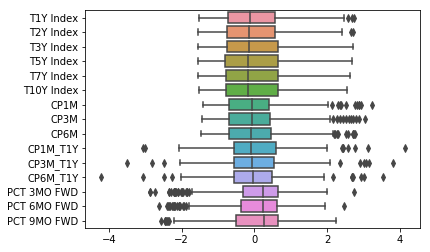

In [3]:
#boxplot
def make_boxplot(df, cols):
    
    #standardize data without any change to the original DataFrame
    tmp1 = copy.deepcopy(df)
    #vectorization way
    normalized_df=(tmp1- tmp1.mean())/tmp1.std()
    #if we instead want to use min-max: normalized_df=(df-df.min())/(df.max()-df.min())
    sns.boxplot(data =normalized_df, orient = 'h') #orient for better display
    plt.show()

make_boxplot(econData, econData.columns)

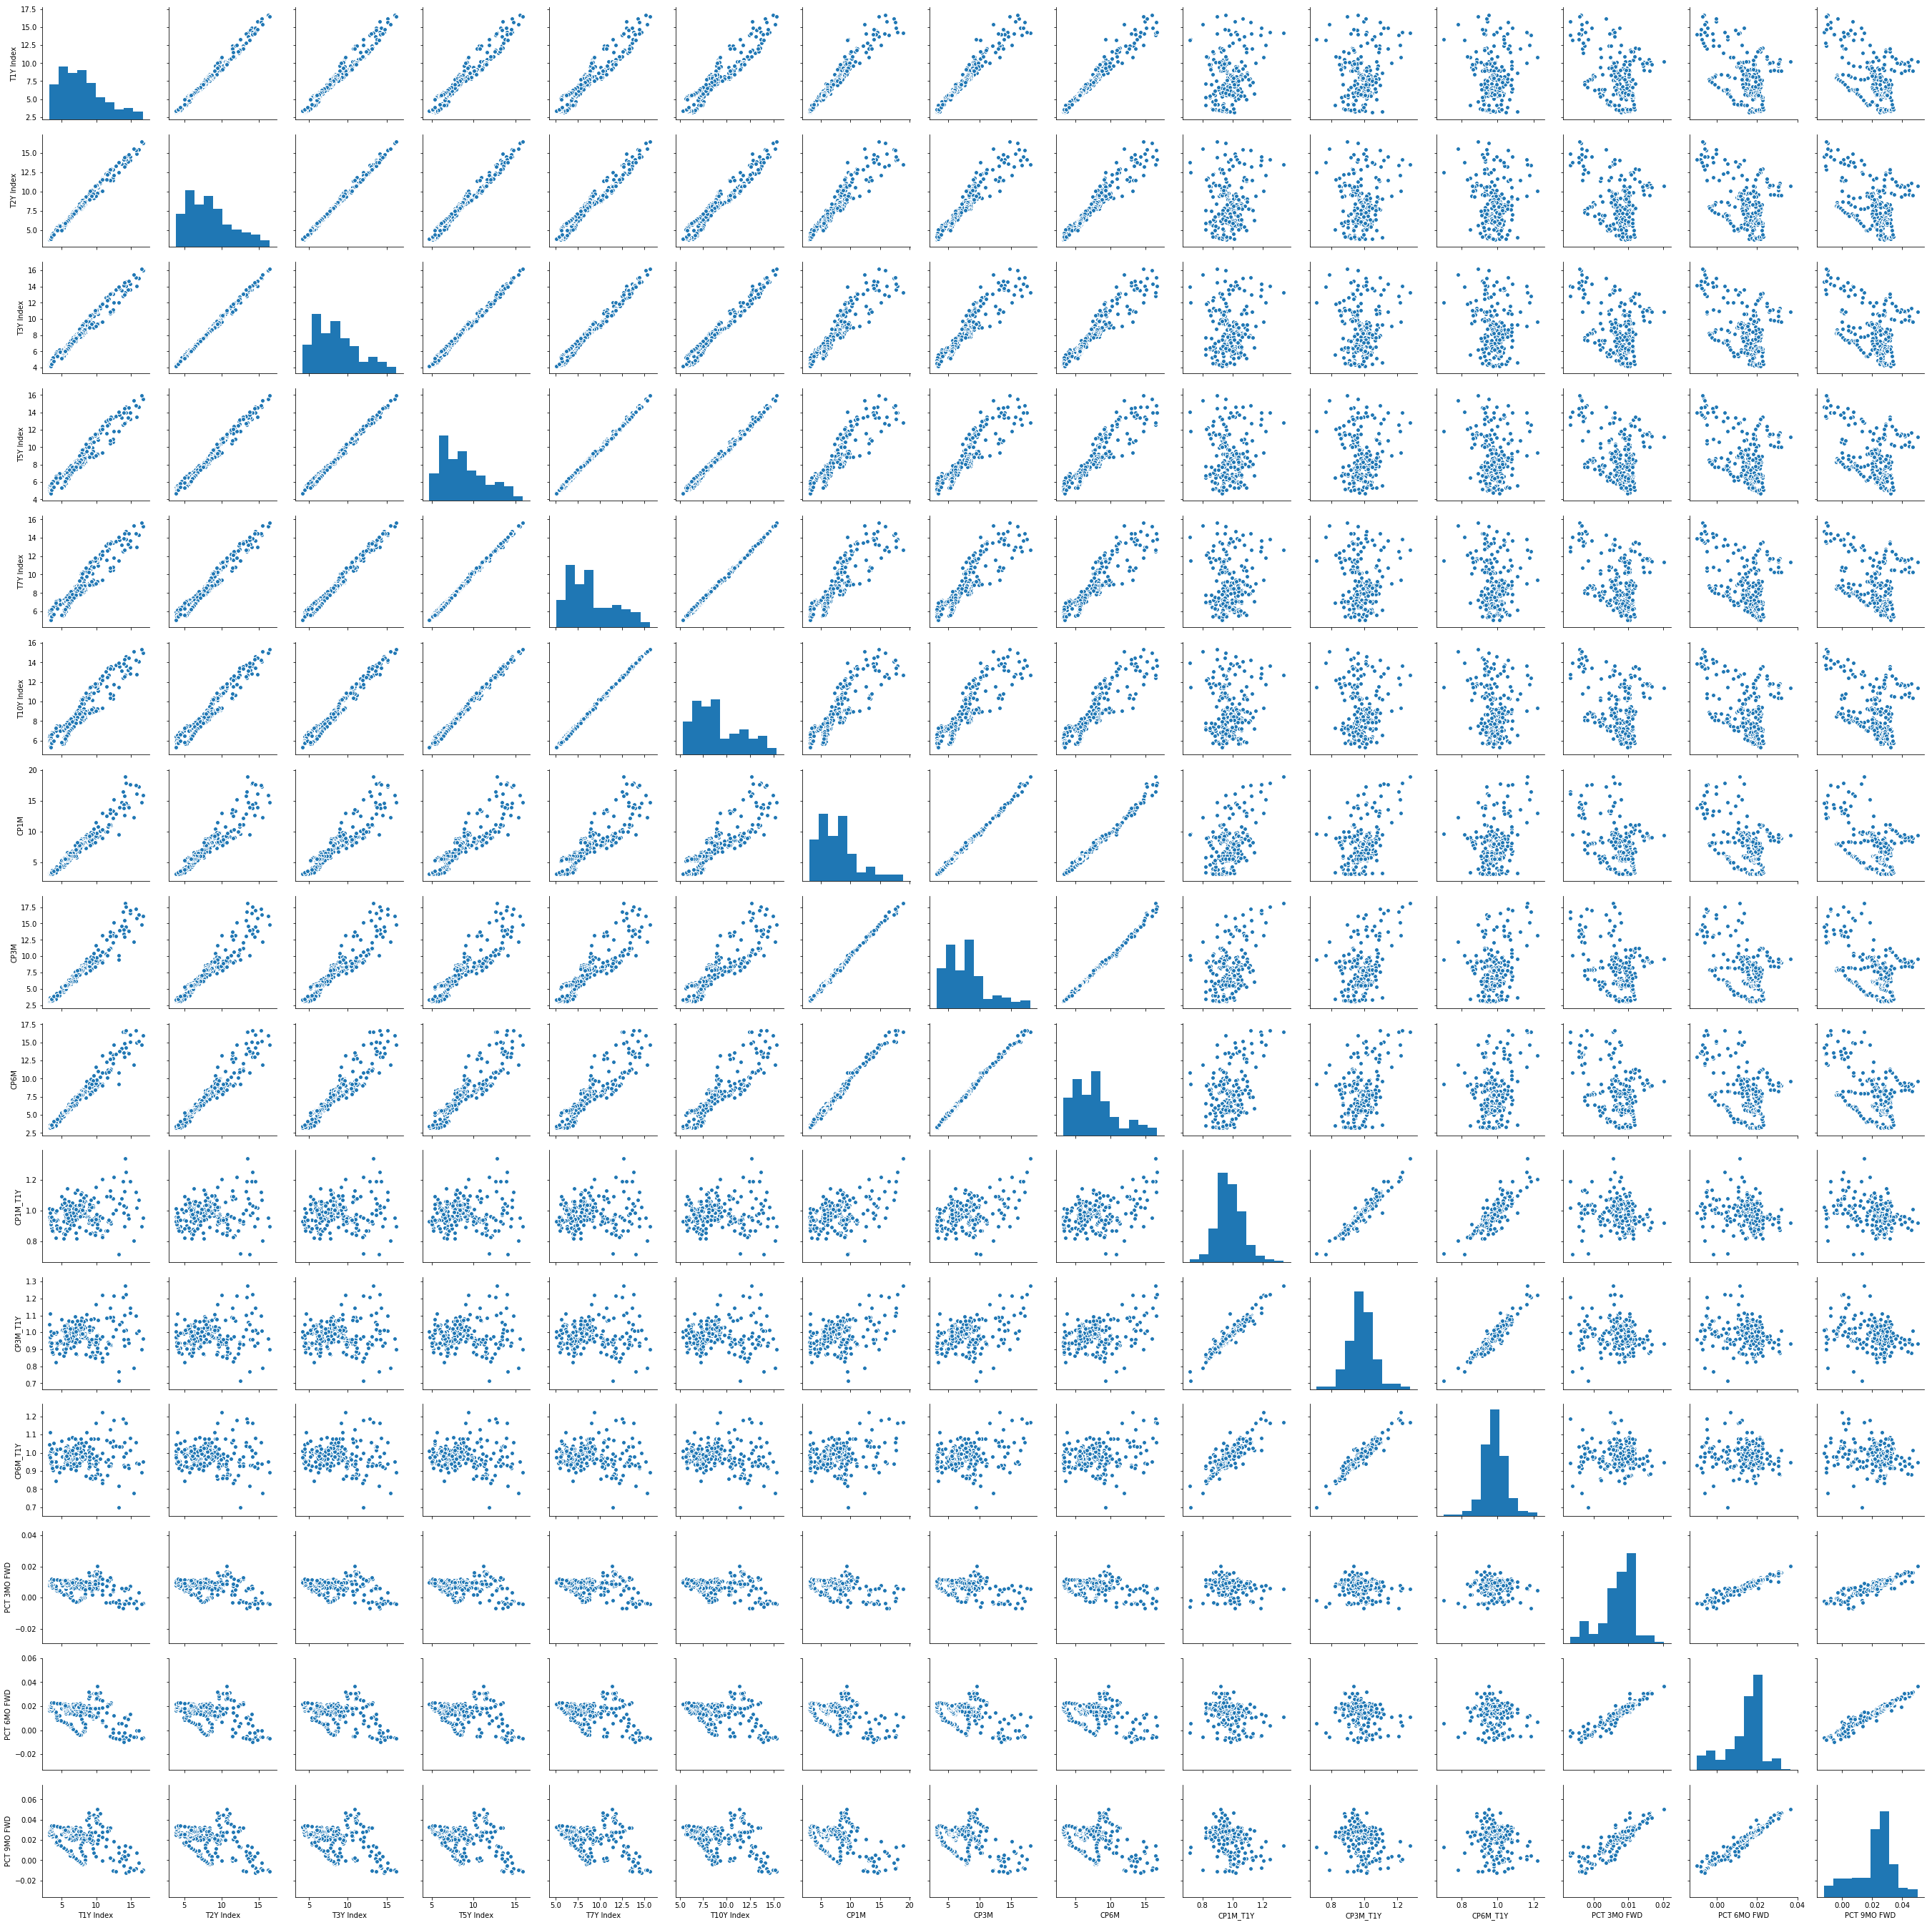

In [4]:
def make_scatter(df, cols):
    sns.pairplot(df[cols], size = 2.5)
    plt.show()

make_scatter(econData, econData.columns)

Index(['T1Y Index', 'T2Y Index', 'T3Y Index', 'T5Y Index', 'T7Y Index',
       'T10Y Index', 'CP1M', 'CP3M', 'CP6M', 'CP1M_T1Y', 'CP3M_T1Y',
       'CP6M_T1Y', 'PCT 3MO FWD', 'PCT 6MO FWD', 'PCT 9MO FWD'],
      dtype='object')


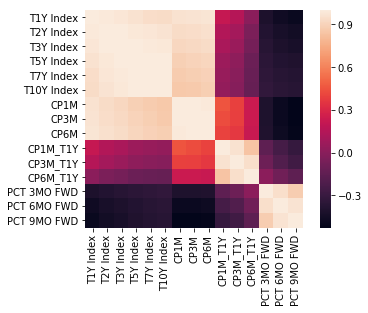

In [5]:
#Heatmap
def make_heatmap(df, cols):
    corMat = df[cols].corr()
    sns.heatmap(corMat, cbar = True, annot = False, square = True, fmt ='.2f',
                annot_kws = {'size' : 10}, yticklabels = cols, xticklabels = cols)
    plt.show()

print(econData.columns)
make_heatmap(econData, econData.columns)

In [6]:
#preprocesing 
X = econData.iloc[:,:12].values
#predicting PCT 3MO FMD
y = econData.iloc[:, 14].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

sc  = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test) # no need to fit the test data


In [21]:
class ModelEval(object): 
    def __init__(self, regressor, X_train, X_test, y_train, y_test):
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.regressor = regressor.fit(X_train, y_train)
        self.y_train_pred = (regressor.predict(X_train)).reshape((-1,1))
        self.y_test_pred = (regressor.predict(X_test)).reshape((-1,1))
        
    
    def model_result(self, title):
        if type(self.regressor) == sklearn.pipeline.Pipeline or self.regressor != r'Linear+':
            pass
        else:  
            print('coef:', self.regressor.coef_)
            print('intercept:', self.regressor.intercept_)
        print('MSE train: %.5f, test: %.5f' %(mean_squared_error(y_train,self.y_train_pred)
    , mean_squared_error(y_test, self.y_test_pred)))

        print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, self.y_train_pred)
    ,r2_score(y_test, self.y_test_pred)))
        plt.scatter(self.y_train_pred,  self.y_train_pred - y_train,
                c='steelblue', marker='o', edgecolor='white',
                label='Training data')
        plt.scatter(self.y_test_pred,  self.y_test_pred - y_test,
                c='limegreen', marker='s', edgecolor='white',
                label='Test data')
        plt.xlabel('Predicted values')
        plt.ylabel('Residuals')
        plt.title(title)
        plt.legend(loc='upper left')
        plt.hlines(y=0, xmin= min(self.y_test_pred) -0.005 , xmax= max(self.y_test_pred)+0.005, color='black', lw=2)
        plt.xlim([min(self.y_test_pred) -0.005, max(self.y_test_pred)+0.005])
        plt.tight_layout()
        plt.show()
        

In [22]:
class HyperTuning(object):
    def __init__(self, estimator, param_grid, scoring, 
                 X_train, y_train, cv = 10):
        
        self.param_grid = param_grid
        self.scoring = scoring
        self.X_train = X_train
        self.y_train = y_train
        self.estimator = estimator.fit(X_train, y_train)
        
    def gs_tune(self):
        gs = GridSearchCV(estimator = self.estimator, param_grid = self.param_grid,
                         scoring = self.scoring, cv = 10, n_jobs = 4, verbose = 0)
        gs.fit(X_train, y_train)
        print(f'best param is {gs.best_params_}, best score is {gs.best_score_}')
        return gs.best_estimator_
           

MSE train: 0.00012, test: 0.00009
R^2 train: 0.349, test: 0.322


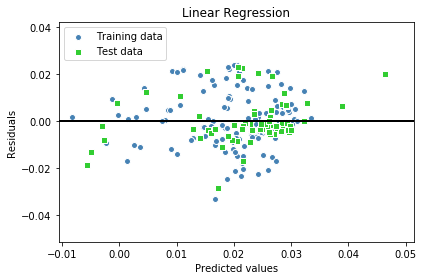

In [23]:
#Regular linear
linreg_title = 'Linear Regression'
linreg_eval = ModelEval(LinearRegression(), X_train_std, X_test_std, y_train, y_test)
linreg_eval.model_result(linreg_title )

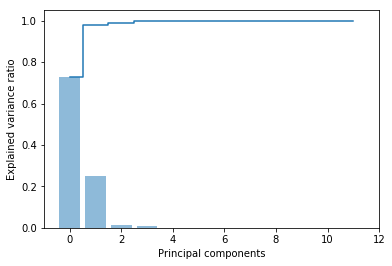

best param is {'pca__n_components': 8}, best score is 0.11599702162906525
MSE train: 0.00013, test: 0.00009
R^2 train: 0.289, test: 0.323


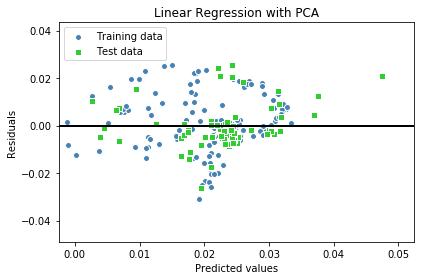

In [24]:
#LinReg with pca
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

plt.bar(range(0,12), pca.explained_variance_ratio_, alpha = 0.5, align = 'center')
plt.step(range(0,12), np.cumsum(pca.explained_variance_ratio_), where = 'mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

linreg_pca = Pipeline(steps = [('pca', pca), ('linear', LinearRegression())])
param_grid = {
    'pca__n_components': [2,4,6,8,10]
}
linreg_pca_tuning = HyperTuning(linreg_pca, param_grid, 'r2', X_train_std, y_train,  cv =10)
linreg_pca_best = linreg_pca_tuning.gs_tune()
linreg_pca_eval = ModelEval(linreg_pca_best, X_train_std, X_test_std, y_train, y_test)
linreg_pca_eval.model_result(title = 'Linear Regression with PCA' )


best param is {'kpca__gamma': 0.0829, 'kpca__kernel': 'rbf', 'kpca__n_components': 10}, best score is 0.4134387988902158
MSE train: 0.00007, test: 0.00007
R^2 train: 0.591, test: 0.496


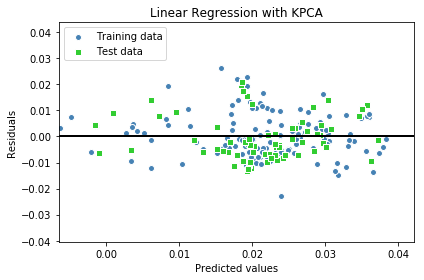

In [25]:
#LinReg with kpca
kpca = KernelPCA()
linreg_kpca = Pipeline(steps = [('kpca', kpca), ('linear', LinearRegression())])
param_grid = {
    'kpca__n_components':[2,4,6,8,10],
    'kpca__kernel': [ 'linear', 'poly', 'rbf', 'sigmoid'],
    'kpca__gamma': [ 0.001, 0.01, 0.0829]
    
}
linreg_kpca_tuning = HyperTuning(linreg_kpca, param_grid, 'r2', X_train_std, y_train,  cv =10)
linreg_kpca_best = linreg_kpca_tuning.gs_tune()
linreg_kpca_eval = ModelEval(linreg_kpca_best, X_train_std, X_test_std, y_train, y_test)
linreg_kpca_eval.model_result(title = 'Linear Regression with KPCA' )

best param is {'alpha': 0.01, 'l1_ratio': 0.01}, best score is 0.09994538714763342
MSE train: 0.00013, test: 0.00008
R^2 train: 0.278, test: 0.394


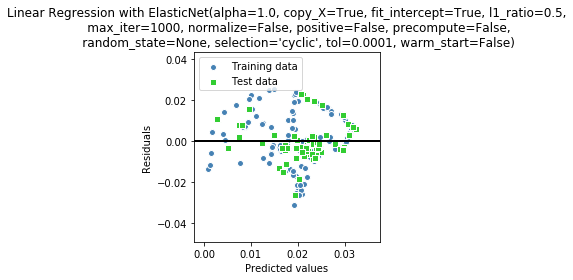

In [26]:
#  LR with Elastic Net
# elastic = ElasticNet()
# elastic.get_params().keys()
elastic = ElasticNet()
param_space_ele = np.arange(0.01,1,0.01).tolist()
param_grid = {
    'alpha' : param_space_ele,
    'l1_ratio': param_space_ele
}
def tuning_and_res(model, param_grid):
    
    model_tuning = HyperTuning(model, param_grid, 'r2', X_train_std, y_train,  cv =10)
    model_best = model_tuning.gs_tune()
    model_eval = ModelEval(model_best, X_train_std, X_test_std, y_train, y_test)
    model_eval.model_result(title = f'Linear Regression with {model}' )

tuning_and_res(elastic, param_grid)



In [27]:
import tensorflow as tf
import tensorflow.contrib.keras as keras
np.random.seed(123)
tf.set_random_seed(123)

MSE train: 0.00035, test: 0.00064
R^2 train: -0.934, test: -3.609
Epoch 1/1
156/156 [==============================] - 0s 73us/step - loss: 3.5340e-04
MSE train: 0.00035, test: 0.00064
R^2 train: -0.933, test: -3.602


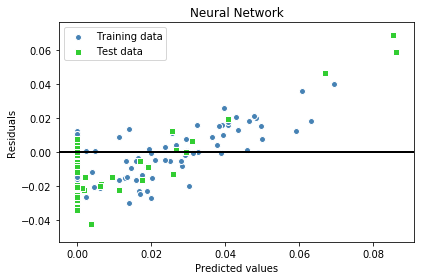

In [28]:
model_nn = keras.models.Sequential()
model_nn.add(
    keras.layers.Dense(
    units=50,
    input_dim=X_train_std.shape[1],
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation='tanh'))

model_nn.add(
    keras.layers.Dense(
    units=50,
    input_dim=50,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation='tanh'))

model_nn.add(
    keras.layers.Dense(1, activation = 'relu'))
model_nn.compile(loss='mean_squared_error', optimizer='sgd')
model_nn.fit(X_train_std, y_train, epochs=1000, verbose=0)
y_train_pred_nn = model_nn.predict(X_train_std)
y_test_pred_nn = model_nn.predict(X_test_std)

print('MSE train: %.5f, test: %.5f' %(mean_squared_error(y_train, y_train_pred_nn)
    , mean_squared_error(y_test, y_test_pred_nn)))

print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred_nn)
    ,r2_score(y_test, y_test_pred_nn)))


neural_eval = ModelEval(model_nn, X_train_std, X_test_std, y_train, y_test)
neural_eval.model_result(title = 'Neural Network' )

MSE for untuned xgboost is 0.000
R-squared for untuned xgboost is 0.556
MSE train: 0.00000, test: 0.00006
R^2 train: 0.987, test: 0.556


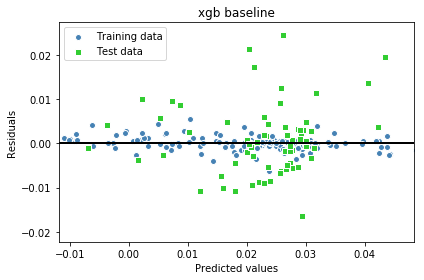

In [29]:
#Ensemble using EXtreme Gradient Boosting
xgb_baseline = xgb.XGBRegressor( learning_rate = 0.1, n_estimators=100, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=1,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed = 42, return_train_score = True,
                         scoring='r2',n_jobs=4,iid=False)
xgb_baseline.fit(X_train_std,y_train)
y_pred = xgb_baseline.predict(X_test_std)
print(f'MSE for untuned xgboost is {mean_squared_error(y_test, y_pred):.3f}')
print(f'R-squared for untuned xgboost is {r2_score(y_test,y_pred):.3f}')

xgb_base_eval = ModelEval(xgb_baseline, X_train_std, X_test_std, y_train, y_test)
xgb_base_eval.model_result(title = 'xgb baseline' )

MSE for tuned xgboost using GridSearch is 0.000
R-squared for tuned xgboost using GridSearch is 0.566
MSE for tuned xgboost using RandomSearch is 0.000
R-squared for tuned xgboost using RandomSearch is 0.585
MSE train: 0.00000, test: 0.00006
R^2 train: 0.993, test: 0.566


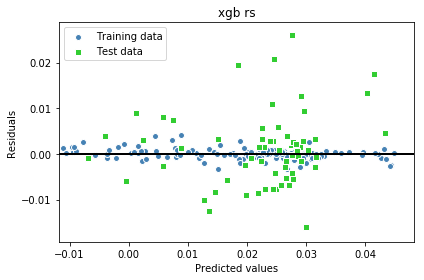

MSE train: 0.00000, test: 0.00006
R^2 train: 0.996, test: 0.585


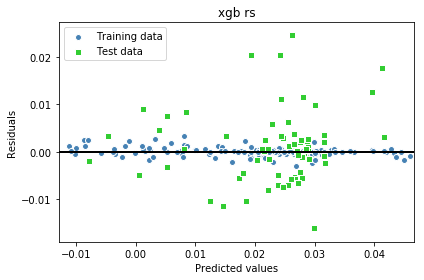

In [34]:
param_test1 = {
 'max_depth':range(3,17,1),
 'min_child_weight':range(1,7,1)
}

xgb_init = xgb.XGBRegressor( learning_rate = 0.1, n_estimators=100, gamma=0, subsample=0.8, colsample_bytree=1,
 objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed = 42, return_train_score = True,
                         scoring='r2',n_jobs=4,iid=False)

xgb_gs = GridSearchCV(xgb_init, param_grid = param_test1,
                         scoring = 'r2', cv = 10, n_jobs = 4, verbose = 0)
xgb_gs.fit(X_train_std, y_train)
y_pred_grid = xgb_gs.best_estimator_.predict(X_test_std)
print(f'MSE for tuned xgboost using GridSearch is {mean_squared_error(y_test, y_pred_grid):.3f}')
print(f'R-squared for tuned xgboost using GridSearch is {r2_score(y_test,y_pred_grid):.3f}')


xgb_rs = RandomizedSearchCV(xgb_init, param_distributions=param_test1, cv=10)
xgb_rs.fit(X_train_std, y_train)

#try two search techniques
y_pred_rand = xgb_rs.best_estimator_.predict(X_test_std)
print(f'MSE for tuned xgboost using RandomSearch is {mean_squared_error(y_test, y_pred_rand):.3f}')
print(f'R-squared for tuned xgboost using RandomSearch is {r2_score(y_test,y_pred_rand):.3f}')


xgb_gs_eval = ModelEval(xgb_gs.best_estimator_, X_train_std, X_test_std, y_train, y_test)
xgb_gs_eval.model_result(title = 'xgb rs' )


xgb_rs_eval = ModelEval(xgb_rs.best_estimator_, X_train_std, X_test_std, y_train, y_test)
xgb_rs_eval.model_result(title = 'xgb rs' )


Code to Report

In [31]:
print("Features,Mean,Median,Standard Deviation,Skewness,Kurtosis")
class CodetoReport(object):
    def __init__(self):
        pass
    def statistics_eda(df, cols):
        for i in range(0, len(cols)):
            column = df[df.columns[i]]
            row = [df.columns[i], str(column.mean()), str(column.median()), str(column.std()), str(column.skew()), str(column.kurt())]
            print(",".join(row))
CodetoReport.statistics_eda(econData, econData.columns)

Features,Mean,Median,Standard Deviation,Skewness,Kurtosis
T1Y Index,8.030717488789234,7.67,3.15857454820757,0.7106762158111719,-0.03921597670742116
T2Y Index,8.410672645739913,8.0,2.954430631495762,0.6487235877088264,-0.21448694932433687
T3Y Index,8.563587443946194,8.13,2.8204046815607082,0.6612862535996927,-0.24909404478268637
T5Y Index,8.808654708520178,8.33,2.6477415128700685,0.6892893735808049,-0.35718357702951
T7Y Index,8.979775784753368,8.52,2.542685578183246,0.6654393962200067,-0.45479749923997437
T10Y Index,9.07349775784753,8.61,2.4475253836014303,0.6626290846216222,-0.5029082339440678
CP1M,7.942197309417037,7.73,3.405098339201436,1.0036549006417597,0.9086134783365063
CP3M,7.936905829596415,7.72,3.3293541327924925,0.9359045658321133,0.6342600105147884
CP6M,7.892780269058299,7.62,3.1814210634608475,0.8270844397690659,0.29050842211355565
CP1M_T1Y,0.981764963013453,0.9726708070000001,0.0862432277969243,0.45877270181838686,1.7298777256747107
CP3M_T1Y,0.9835244850089692,0.977941176,